In [532]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [533]:
trainDF = pd.read_csv('train.csv')
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [534]:
testDF = pd.read_csv('test.csv')
testDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [535]:
concatDF = pd.concat([trainDF,testDF])
concatDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70000 entries, 0 to 27999
Columns: 785 entries, label to pixel783
dtypes: float64(1), int64(784)
memory usage: 419.8 MB


In [536]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, DF):
        if 'label' in DF.columns:
            self.label = pd.get_dummies(DF['label']).values
            DF = DF.drop(columns=['label'])
        self.data = DF.values
        pass

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x=self.data[idx].reshape(1,28,28)
        x=torch.FloatTensor(x)

        if hasattr(self,'label'):
            y=self.label[idx]
            y=torch.FloatTensor(y)

            return x, y
        else:
            return x

dataSet= MyDataset(DF=trainDF)
testSet = MyDataset(DF= testDF)
dataSet[0][0]

tensor([[[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 188., 255.,
           94.,   0.,   0.,   0.,   0.,   0.],
     

In [537]:
splitSet = torch.utils.data.random_split(dataSet,(0.8,0.2))
splitSet

In [538]:
trainLoader=torch.utils.data.DataLoader(splitSet[0],batch_size=2048,sampler=torch.utils.data.RandomSampler(splitSet[0]))
valLoader=torch.utils.data.DataLoader(splitSet[1],batch_size=2048,sampler=torch.utils.data.RandomSampler(splitSet[1]))
testLoader = torch.utils.data.DataLoader(testSet,batch_size=2048)
trainLoader

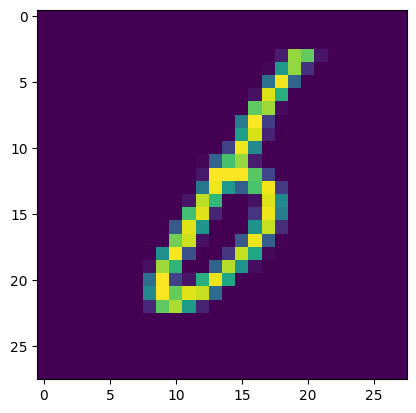

In [539]:
# get some random training images
dataiter = iter(trainLoader)
# images, labels = next(dataiter)
images, label = next(dataiter)

# show images
plt.imshow(images[0][0])

In [540]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.convStack = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, 3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Conv2d(1, 1, 3),
            torch.nn.ReLU(),
            # torch.nn.MaxPool2d(2, 2),
            torch.nn.Flatten(),
            torch.nn.Linear(121, 60),
            torch.nn.ReLU(),
            torch.nn.Linear(60, 10),
        )

    def forward(self, x):
        logits = self.convStack(x)
        return logits



model = Net().to(device)

Using mps device


In [541]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters())

In [542]:
def trainAI(dataLoader, model, loss_fn, optimizer):
    model.train()
    trainLoss=0
    for  X, y in dataLoader:
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        trainLoss +=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return trainLoss

In [543]:
def valAI(dataLoader, model, loss_fn,):
    model.eval()
    valLoss=0
    with torch.no_grad():
        for X,y in dataLoader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            valLoss+=loss.item()
    
    return valLoss

epoch: 0 - train loss: 4.263714239001274 - val loss: 1.4076517820358276
epoch: 1 - train loss: 4.257432505488396 - val loss: 1.288486272096634
epoch: 2 - train loss: 4.252646505832672 - val loss: 1.3551431447267532
epoch: 3 - train loss: 4.215101137757301 - val loss: 1.2997724413871765
epoch: 4 - train loss: 4.223192542791367 - val loss: 1.3383262157440186
epoch: 5 - train loss: 4.178636208176613 - val loss: 1.285864219069481
epoch: 6 - train loss: 4.159013092517853 - val loss: 1.2436471283435822
epoch: 7 - train loss: 4.145845115184784 - val loss: 1.3396171629428864
epoch: 8 - train loss: 4.137630686163902 - val loss: 1.37748184800148
epoch: 9 - train loss: 4.108215108513832 - val loss: 1.289389580488205
epoch: 10 - train loss: 4.142012819647789 - val loss: 1.281483992934227
epoch: 11 - train loss: 4.104003936052322 - val loss: 1.3033248037099838
epoch: 12 - train loss: 4.095970839262009 - val loss: 1.2369097620248795
epoch: 13 - train loss: 4.042378917336464 - val loss: 1.29927548766

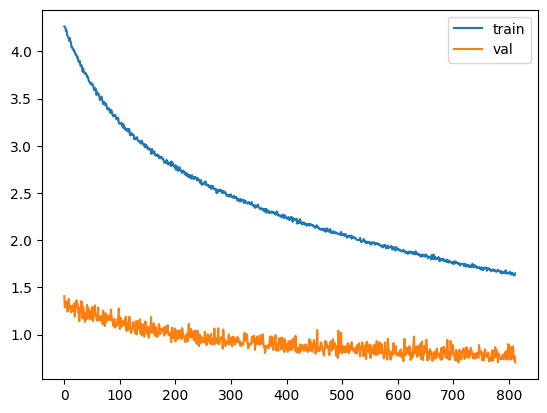

In [549]:
trainHistory,valHistory,=[],[]
previousLoss = float('inf')
cnt =0 
bestModel = model
for epoch in range(10000):

    trainLoss = trainAI(trainLoader, model, loss_fn, optimizer) 
    valLoss = valAI(valLoader, model, loss_fn)

    trainHistory.append(trainLoss)
    valHistory.append(valLoss)

    print(f'epoch: {epoch} - train loss: {trainLoss} - val loss: {valLoss}')

    if cnt >100:
        break
    elif previousLoss < valLoss:
        cnt +=1
    else:
        previousLoss = valLoss
        bestModel = model
        cnt =0 

plt.plot(trainHistory,label='train')
plt.plot(valHistory, label='val')
plt.legend() 

In [550]:
def testAI(dataloader, model):
    model.eval()
    out = []
    y=1
    with torch.no_grad():
        for X in dataloader:
            X  = X.to(device)
            pred = model(X)
            for i in pred:
                out.append([y, torch.argmax(i).item()])
                y+=1

    
    return out

result = testAI(testLoader, bestModel) 
# result = testAI(testLoader[0], model[0])
result

[[1, 2],
 [2, 0],
 [3, 9],
 [4, 9],
 [5, 3],
 [6, 7],
 [7, 0],
 [8, 3],
 [9, 0],
 [10, 3],
 [11, 5],
 [12, 7],
 [13, 4],
 [14, 0],
 [15, 4],
 [16, 3],
 [17, 3],
 [18, 1],
 [19, 9],
 [20, 0],
 [21, 9],
 [22, 1],
 [23, 1],
 [24, 5],
 [25, 7],
 [26, 4],
 [27, 2],
 [28, 7],
 [29, 4],
 [30, 7],
 [31, 7],
 [32, 5],
 [33, 4],
 [34, 2],
 [35, 6],
 [36, 2],
 [37, 5],
 [38, 5],
 [39, 1],
 [40, 6],
 [41, 7],
 [42, 7],
 [43, 4],
 [44, 9],
 [45, 8],
 [46, 7],
 [47, 8],
 [48, 8],
 [49, 6],
 [50, 7],
 [51, 6],
 [52, 8],
 [53, 8],
 [54, 3],
 [55, 8],
 [56, 2],
 [57, 1],
 [58, 2],
 [59, 2],
 [60, 0],
 [61, 4],
 [62, 1],
 [63, 7],
 [64, 0],
 [65, 0],
 [66, 0],
 [67, 1],
 [68, 9],
 [69, 0],
 [70, 1],
 [71, 6],
 [72, 5],
 [73, 8],
 [74, 8],
 [75, 2],
 [76, 8],
 [77, 8],
 [78, 9],
 [79, 2],
 [80, 3],
 [81, 5],
 [82, 4],
 [83, 1],
 [84, 0],
 [85, 9],
 [86, 2],
 [87, 4],
 [88, 3],
 [89, 6],
 [90, 7],
 [91, 2],
 [92, 0],
 [93, 6],
 [94, 6],
 [95, 1],
 [96, 4],
 [97, 3],
 [98, 9],
 [99, 7],
 [100, 4],
 [101, 0

In [551]:
outDF= pd.DataFrame(result)
outDF= outDF.astype(int)
outDF.columns=['ImageId','Label']
outDF

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [552]:
outDF.to_csv('result.csv',index=False)